In [43]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga
import pandas as pd
from io import StringIO

paths_str = """node_from	node_to	distance
1	2	220
1	3	1500
2	4	650
2	5	900
4	7	500
5	7	400
3	6	500
6	7	400
"""

paths = pd.read_csv(StringIO(paths_str), sep="\t")
paths

,node_from,node_to,distance
0,1,2,220
1,1,3,1500
2,2,4,650
3,2,5,900
4,4,7,500
5,5,7,400
6,3,6,500
7,6,7,400


- Terms
    - $x_{ij}$: 노드 i에서 노드 j로 가는 길 선택 시 1, 아니면 0
    - $D_{ij}$: 노드 i에서 노드 j 사이의 거리
- Objective: $minimize(\sum x_{ij} D_{ij})$
- Constraints:
    1. $\sum_{j} x_{ji} = \sum_{k} x_{ik} \quad \forall i \notin \{1, 7\}$
    2. $\sum_{i} x_{1i} = 1$
    3. $\sum_{i} x_{i7} = 1$

- 변경: $x_{ij}$를 Variable로 대신에 실제 연결된 Path만 고려하도록 변경(Variable 수 7x7=49개에서 8개로 감소)
- Path 8개에 대해 각 Path의 사용 여부를 함수의 인자로 받기 → $x_{ij}$ 형태로 mapping 후 Constraints 적용

In [44]:
node_count = 7
path_count = len(paths)

In [45]:
def create_distance_table(paths):
    distance_table = np.array([ [ -1 for j in range(node_count + 1)] for i in range(node_count + 1) ])
    for index, row in paths.iterrows():
        distance_table[row['node_from'], row['node_to']] = row['distance']
    return distance_table

distance_table = create_distance_table(paths)
distance_table

array([[  -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1],
       [  -1,   -1,  220, 1500,   -1,   -1,   -1,   -1],
       [  -1,   -1,   -1,   -1,  650,  900,   -1,   -1],
       [  -1,   -1,   -1,   -1,   -1,   -1,  500,   -1],
       [  -1,   -1,   -1,   -1,   -1,   -1,   -1,  500],
       [  -1,   -1,   -1,   -1,   -1,   -1,   -1,  400],
       [  -1,   -1,   -1,   -1,   -1,   -1,   -1,  400],
       [  -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1]])

In [46]:
def p_to_x(p):
    # p[i]: i번째 path 사용 여부(0: 미사용, 1: 사용)
    # x[i][j]: i → j 사용 여부(0: 미사용, 1: 사용)
    x = np.array([ [ 0 for j in range(node_count + 1)] for i in range(node_count + 1) ])

    for i, pv in enumerate(p):
        if pv == 1:
            node_from = paths.loc[i, 'node_from']
            node_to = paths.loc[i, 'node_to']
            x[node_from, node_to] = 1
    return x
            
p_to_x([0,1,0,1,0,0,0,0])

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [47]:
p_to_x([0,1,0,1,0,0,0,0]) * distance_table

array([[   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 1500,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,  900,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0]])

In [48]:
def f(p):
    res = 0
    penalty = 0
    x = p_to_x(p)
    
    # penalty를 단순 np.inf로 주면 학습이 잘 안 됨. 원하는 조건에 가까울 수록 낮은 페널티 부과하도록 개선
    for i in range(1, 1 + node_count):
        if i == 1:
            if np.sum(x[1, :]) != 1:
                penalty += np.abs(np.sum(x[1, :]) - 1) * 1000000
        elif i == 7:
            if np.sum(x[:, 7]) != 1:
                penalty += np.abs(np.sum(x[:, 7]) - 1) * 1000000
        else:
            if np.sum(x[:, i]) != np.sum(x[i, :]):
                penalty += np.abs(np.sum(x[:, i]) - np.sum(x[i, :])) * 1000000
    
    total_distance = np.sum(x * distance_table)
    
    return total_distance + penalty

In [49]:
# Test 1 (1 → 2 → 5 → 7)
f([1, 0, 0, 1, 0, 1, 0, 0])

1520

In [50]:
# Test 2 (Not connected)
f([0, 1, 0, 0, 0, 0, 1, 0])

2002000

In [51]:
# Test 3 (1 → 3 → 6 → 7)
f([0, 1, 0, 0, 0, 0, 1, 1])

2400

In [52]:
varbounds = np.array([[0, 1] for p in range(path_count)])

In [53]:
vartype = np.array([['int'] for p in range(path_count)])

In [54]:
algorithm_param = {
    'max_num_iteration': 500,
    'population_size':100,
    'mutation_probability':0.30,
    'elit_ratio': 0.10,
    'crossover_probability': 0.50,
    'parents_portion': 0.30,
    'crossover_type':'uniform',
    'max_iteration_without_improv':100
}

In [55]:
model = ga(function=f, dimension=path_count, variable_type_mixed=vartype, variable_boundaries=varbounds, algorithm_parameters=algorithm_param)

 The best solution found:                                                                           
 [1. 0. 1. 0. 1. 0. 0. 0.]

 Objective function:
 1370.0


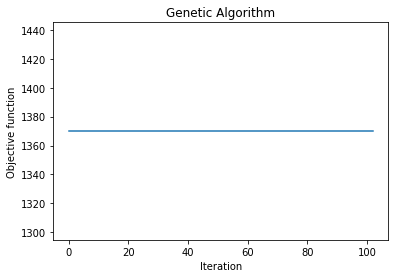

In [58]:
%%time
model.run()